# Continuum Background Estimation

This example shows how to use cosipy for estimating the continuum background. For more details on how the algorithm works, see the other notebook in this directory. In short, the method is based on the traditional on-off analysis, where the background for a source region on the sky is estimated by performing some kind of interpolation of the nearby surrounding region. The main difference with a Compton telescope is that we are now performing the on-off analysis in the Compton data space.

In this particular example, we want to estimate the background for the Crab. We start with the full dataset. This contains the full background, which includes instrumental + astrophysical, where the latter consists of all astrophysical sources other than the Crab. Then, for each bin of Em and Phi, we mask the Crab in the PsiChi plane based on the point source response. Finally, we interpolate over the masked region using an inpainting method.   

The accuracy of this method depends strongly on two things:
1) Choosing the proper source region to mask
2) Making an accurate interpolation

The current source code takes a very simple appoach for both of these, but eventually they need to be improved. For the first point, ultimately we should use the ARM measurement, and we'll need to figure out the optimal percentage of counts to mask. A major challenge here is that point sources have really long tails in the ARM distribution, extending over the entire sky. So we probably can't use a typical confidence level of 95% for the masking. For the second point, we are currently using the simplest possible inpainting algorithm. More sophisticated methods are needed. The best alrorithm will likely come from deep convolution neural networks. An alterantive to inpainting methods is to use background templates, which can be scaled outside of the masked region. The code also needs to be developed in a way that will make this easy to do. Finally, the code is super slow and needs to be vectorized. 

In [1]:
from cosipy.background_estimation import ContinuumEstimation
from cosipy.util import fetch_wasabi_file
import os
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)
%matplotlib inline

12:46:35 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=253941;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=150982;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=117555;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=133774;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=477958;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=574605;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

         INFO      Starting 3ML!                                                                     ]8;id=345539;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=941158;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py#39\39]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=530499;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=758670;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=377382;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=176548;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py#41\41]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=439994;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=310012;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py#44\44]8;;\

         WARNING   no display variable set. using backend for graphics without display (agg)         ]8;id=741805;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=551527;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py#50\50]8;;\

12:46:36 WARNING   ROOT minimizer not available                                                ]8;id=990463;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=481711;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=810627;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=384571;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=633511;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=438451;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

12:46:36 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=809165;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=505538;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=506988;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=983474;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=89373;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=377450;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

12:46:37 WARNING   No fermitools installed                                              ]8;id=348674;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=429093;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

12:46:37 WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=560111;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=719328;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=236838;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=682264;file:///project/majello/astrohe/ckarwin/MyEnvironments/COSI/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

The notebook requires the following files:
1) 20280301_3_month.ori
2) SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.earthocc.h5
3) crab_bkg_binned_data_galactic.hdf5
4) inputs_crab.yaml

They can be downloaded using the cells below.

In [ ]:
# Detector response file
# Make sure to unzip file after downloading!
fetch_wasabi_file('COSI-SMEX/DC2/Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip')

In [ ]:
# crab_bkg_binned_data_galactic.hdf5
fetch_wasabi_file('COSI-SMEX/cosipy_tutorials/background_estimation/crab_bkg_binned_data_galactic.hdf5')

In [ ]:
# inputs_crab.yaml
fetch_wasabi_file('COSI-SMEX/cosipy_tutorials/background_estimation/inputs_crab.yaml')

In [ ]:
# 20280301_3_month.ori
fetch_wasabi_file('COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori')

Define instance of class:

In [2]:
instance = ContinuumEstimation()

In order to estimate the background, we need the point source response. If you don't already have this, you can calculate it, as shown below. Note that the coordinates of the Crab need to be passed as a tuple, giving Galactic longitude and latitude in degrees. 

In [3]:
data_path = "your/path"

# Orientatin file:
ori = os.path.join(data_path,"20280301_3_month.ori")

# Detector response:
dr = os.path.join(data_path,\
        "SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.earthocc.h5")

instance.calc_psr(ori, dr, (184.5575, -5.78434), "crab_psr")

Now let's calculate the estimated background. To make a short example, we'll only consider 1 Em bin and 2 Phi bins, as specified by the optional keywords e_loop and s_loop, respectively. We'll also make plots here for demonstrational purposes. 

INFO:yayc.configurator:Using configuration file at inputs_crab.yaml
INFO:cosipy.background_estimation.ContinuumEstimation:...loading the pre-computed image response ...
INFO:cosipy.background_estimation.ContinuumEstimation:--> done
  0%|          | 0/2 [00:00<?, ?it/s]INFO:cosipy.background_estimation.ContinuumEstimation:Bin 2 4


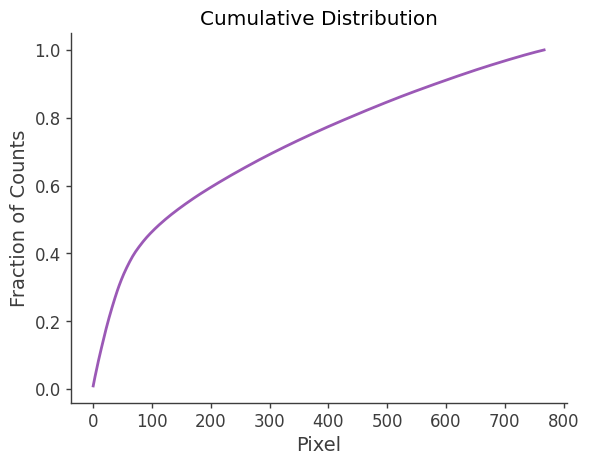

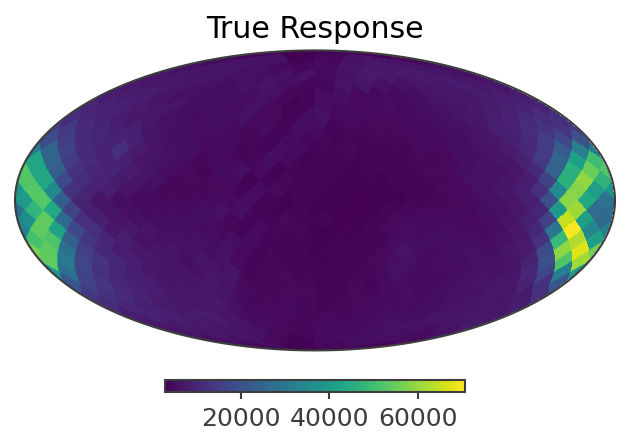

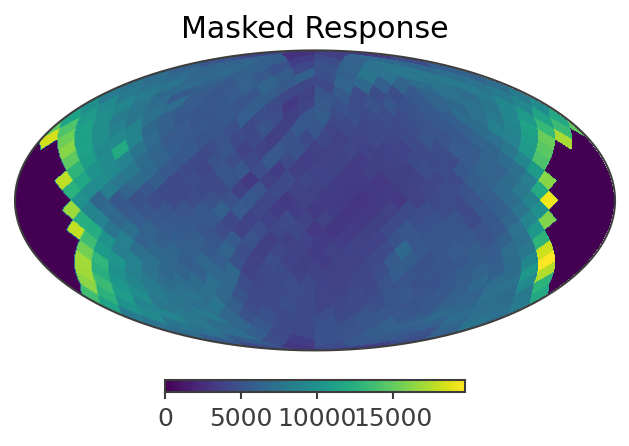

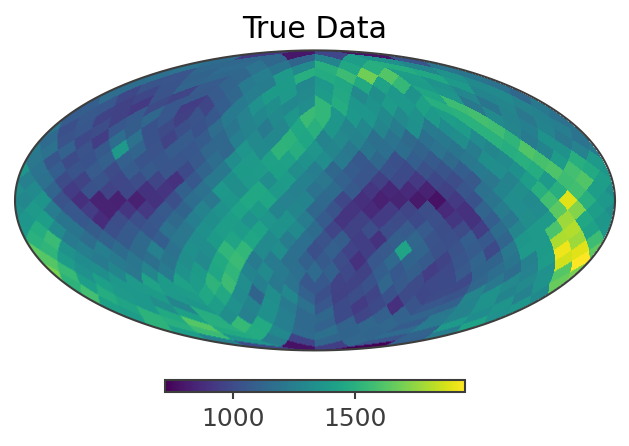

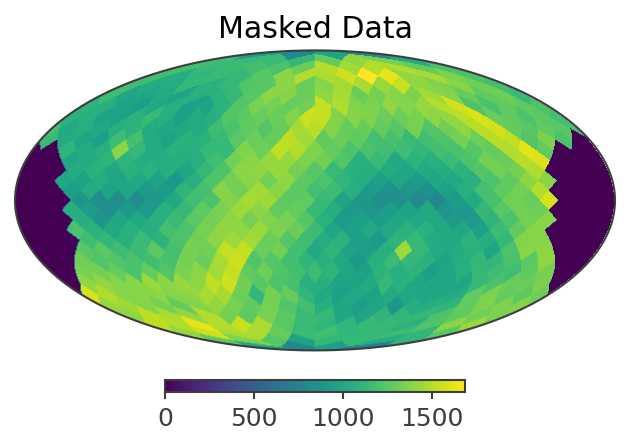

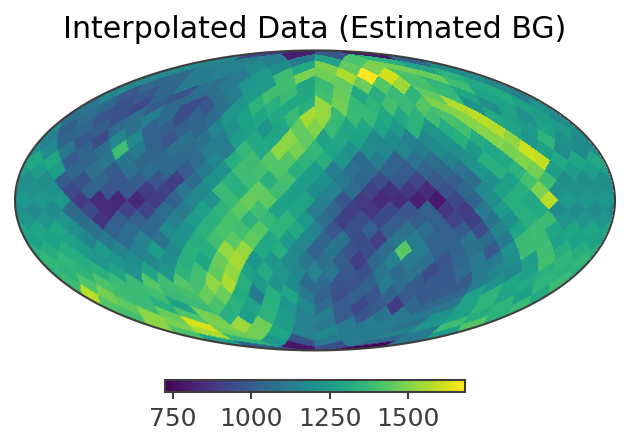

100%|██████████| 2/2 [00:38<00:00, 19.19s/it]INFO:cosipy.background_estimation.ContinuumEstimation:Bin 2 5


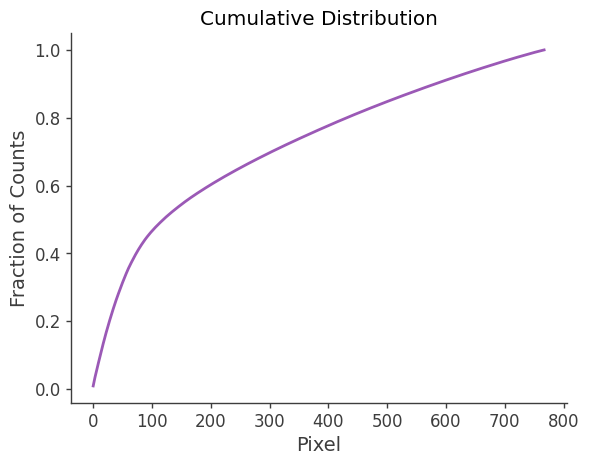

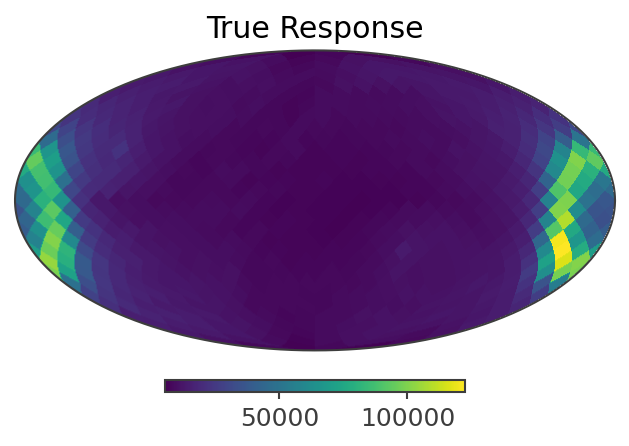

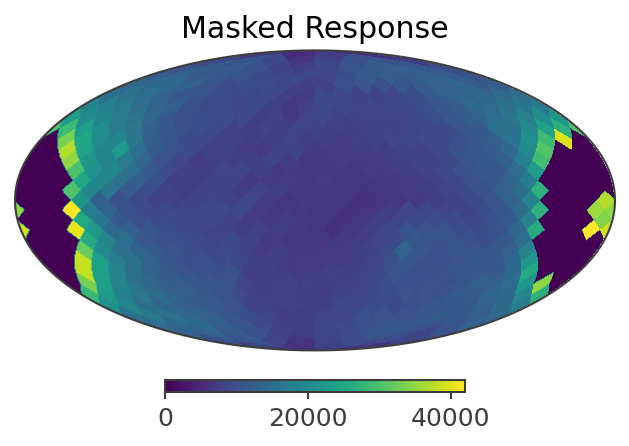

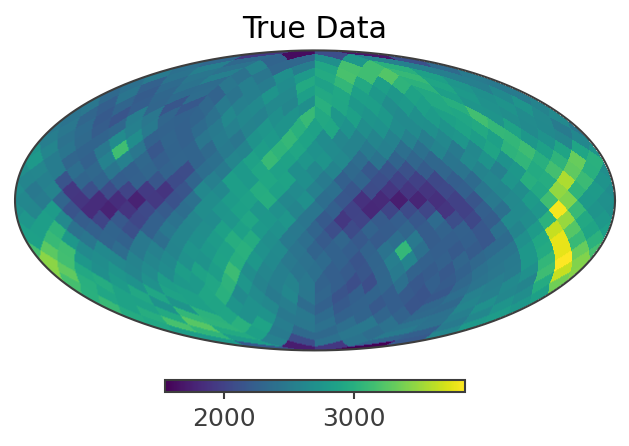

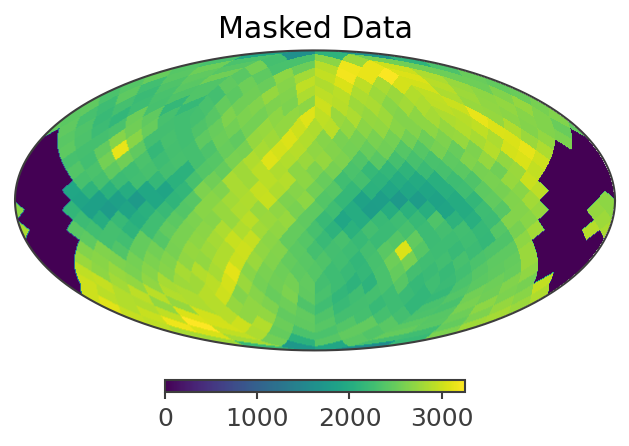

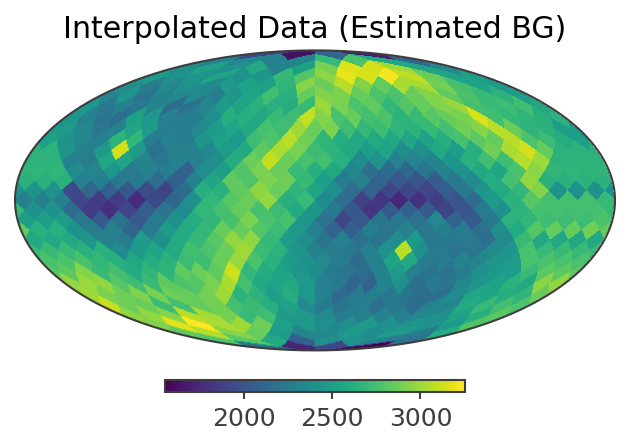

100%|██████████| 2/2 [01:14<00:00, 37.07s/it]
INFO:cosipy.background_estimation.ContinuumEstimation:Writing file...
INFO:cosipy.background_estimation.ContinuumEstimation:Finished!


In [3]:
data_file = "crab_bkg_binned_data_galactic.hdf5"
data_yaml = "inputs_crab.yaml"
psr_file = "crab_psr.h5"
instance.continuum_bg_estimation(data_file, data_yaml, psr_file, "estimated_bg", make_plots=True, e_loop=(2,3), s_loop=(4,6))